# Model selection and validation

This script separates the data into train and test splits, conducts cross validation to determine the best performing model per histone data and compression function.

### Setup

In [3]:
import numpy as np
import pandas as pd
import random
import pickle
from my_functions import *

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import seaborn as sns

from progressbar import ProgressBar, Bar, Percentage, AnimatedMarker, AdaptiveETA
from IPython.display import clear_output

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.impute import KNNImputer

import tensorflow_docs as tfdocs
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import regularizers, datasets, layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Bidirectional,Conv1DTranspose, ActivityRegularization, Input, LSTM, ReLU, GRU, multiply, Lambda, PReLU, SimpleRNN, Dense, Activation, BatchNormalization, Conv2D, Conv1D, Flatten, LeakyReLU, Dropout, MaxPooling2D, MaxPooling1D, Reshape

In [4]:
#random seed for reproducibility
tf.random.set_seed(42)
random.seed(42)

In [1]:
def filter_metadata(metadata, cancer = False, biological_replicates = False):
    
    #keep or remove cancer samples
    cancer_indexes = []
    for i in metadata[metadata.Description.notnull()].index:
        description = metadata.loc[i].Description
        if 'cancerous' in description or 'oma' in description:
            cancer_indexes.append(i)  
    if cancer == True: 
        metadata = metadata.loc[cancer_indexes]
    else:
        metadata = metadata.drop(cancer_indexes)
    
    #keep or remove biological replicates
    biological_replicate_experiments = metadata.groupby(['Experiment accession']).count()[metadata.groupby(['Experiment accession']).count()['Biological replicate(s)']>1].index
    if biological_replicates == True:
        metadata = metadata[metadata['Experiment accession'].isin(biological_replicate_experiments)]
    else:
        metadata = metadata[~metadata['Experiment accession'].isin(biological_replicate_experiments)]
    
    return metadata

In [6]:
def validate_classical_models(histone, organism, data_type, model_list, scaler_list, age_transform_list, folds = 5):
    
    #summary
    summary_df = pd.DataFrame(columns = ['Histone', 'Function', 'Scaler', 'Age Transform', 'Model', 'Mean MAE', 'Std MAE', 'Mean MSE', 'Std MSE', 'Mean R2', 'Std R2'])
    
    #get file names for all the compressed histone_data_objects
    directory = 'histone_data/' + organism + '/' + data_type + '/' + histone +'/processed_data/'
    histone_files = [f for f in listdir(directory) if isfile(join(directory, f))]
    histone_files = [f for f in histone_files if histone in f]
    
    #load metadata without the cancer samples
    metadata = pd.read_pickle('histone_metadata/' + organism + '/' + data_type + '/metadata_summary.pkl') 
    metadata = filter_metadata(metadata)
    
    #code to get a progress bar
    widgets = ['Progress: ', Percentage(), '[', Bar(marker=AnimatedMarker()), ']', ' ', AdaptiveETA(), ' ']
    pbar_maxval = len(histone_files)*len(model_list)*len(scaler_list)*len(age_transform_list)
    pbar = ProgressBar(widgets=widgets, maxval = pbar_maxval).start()
    count = 0
    
    #X-fold CV
    cv = KFold(n_splits=folds, random_state=42, shuffle=True)
    
    for file in histone_files:
        
        histone_data_object = pickle.load(open(directory + file, 'rb'))
        
        #ensures both X and y have same samples
        X = histone_data_object.df
        samples = np.intersect1d(X.index, metadata.index)
        y = metadata.loc[samples].age
        X = X.loc[y.index]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)        
        
        #loop through the different age transformers
        for age_transform in age_transform_list:

            #loop through the different scaling methods
            for scaler in scaler_list:

                #loop through the models doing a 10-fold CV
                for model_name in model_list:

                    pipeline = Pipeline(steps = [('imputer', KNNImputer()), scaler, model_name])
                    model = TransformedTargetRegressor(regressor = pipeline, transformer = age_transform[1], check_inverse = False)
                    results = cross_validate(model, X_train, y_train, cv = cv, scoring = {'mae':'neg_median_absolute_error', 'mse':'neg_mean_squared_error', 'r2':'r2'})
                    
                    #evaluation metrics
                    mae = np.mean(np.abs(results['test_mae']))
                    std_mae = np.std(np.abs(results['test_mae']))
                    mse = np.mean(np.abs(results['test_mse']))
                    std_mse = np.std(np.abs(results['test_mse']))
                    r2 = np.mean(results['test_r2'])
                    std_r2 = np.std(results['test_r2'])
                    
                    #update progress bar
                    clear_output()
                    pbar.update(count+1)
                    count+=1
                    
                    #add all the results to one row of the 
                    summary_row =  pd.Series([histone, histone_data_object.function, scaler[0], age_transform[0], model_name[0], mae, std_mae, mse, std_mse, r2, std_r2], index = summary_df.columns)
                    summary_df = summary_df.append(summary_row, ignore_index = True)

    #stop progress bar
    pbar.finish()

    return summary_df

In [7]:
class Blank(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        return X
    
    def inverse_transform(self, X, y = None):
        return X

In [8]:
class LogLinearTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, adult_age = 20):
        self.adult_age = adult_age

    def fit(self, target):
        return self

    def transform(self, target):
        target_ = target.copy().astype(float)
        for i in range(len(target_)):
            if target_[i] < self.adult_age:
                target_[i] = np.log((target_[i] + 1)/(self.adult_age + 1))
            else:
                target_[i] = (target_[i] - self.adult_age)/(1 + self.adult_age)
        return target_
    
    def inverse_transform(self, target):
        target_ = target.copy().astype(float)
        for i in range(len(target_)):
            if target_[i] < 0:
                target_[i] = (1 + self.adult_age)*(np.exp(target_[i]))-1
            else:
                target_[i] = (1 + self.adult_age)*target_[i] + self.adult_age
        return target_

In [9]:
class SigmoidTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, max_lifespan = 122, alpha = 1):
        self.max_lifespan = max_lifespan
        self.alpha = alpha
        self.gestation_time = 40*7/365

    def fit(self, target):
        return self

    def transform(self, target):
        target_ = target.copy().astype(float)
        target_ = target_ + self.gestation_time #make sure that all ages are positive
        target_ = target_/self.max_lifespan
        target_ = np.log(target_/(1-target_))/self.alpha
        return target_
    
    def inverse_transform(self, target):
        target_ = target.copy().astype(float)
        target_ = 1/(1 + np.exp(-target_*self.alpha))
        target_ = target_ * self.max_lifespan - self.gestation_time
        return target_

In [10]:
model_list = [
    ('elastic_net', ElasticNetCV(n_alphas = 10, max_iter=1000, random_state = 42)),
    ('svr', SVR()),
    ('knn', KNeighborsRegressor()),
    ('random_forest', RandomForestRegressor(random_state = 42)),
    ('gbr', GradientBoostingRegressor(random_state = 42)),
]

scaler_list = [
    ('no', Blank()),
    ('standard', StandardScaler()),
    ('robust', RobustScaler()),
    ('quantile', QuantileTransformer(output_distribution='normal', random_state=42)),
]

age_transform_list = [
    ('no', Blank()),
    ('loglinear', LogLinearTransformer()),
]

## Per-mark validation

#### H3K4me3

In [11]:
results_H3K4me3 = validate_classical_models('H3K4me3', 'human', 'tissue', model_list, scaler_list, age_transform_list, folds = 10)

Progress: 100%[|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||] Time: 6:56:36 


#### H3K27ac

In [12]:
results_H3K27ac = validate_classical_models('H3K27ac', 'human', 'tissue', model_list, scaler_list, age_transform_list, folds = 10)

Progress: 100%[|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||] Time: 7:05:07 


#### H3K4me1

In [13]:
results_H3K4me1 = validate_classical_models('H3K4me1', 'human', 'tissue', model_list, scaler_list, age_transform_list, folds = 10)

Progress: 100%[|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||] Time: 6:26:58 


#### H3K9me3

In [14]:
results_H3K9me3 = validate_classical_models('H3K9me3', 'human', 'tissue', model_list, scaler_list, age_transform_list, folds = 10)

Progress: 100%[|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||] Time: 6:15:30 


#### H3K27me3

In [15]:
results_H3K27me3 = validate_classical_models('H3K27me3', 'human', 'tissue', model_list, scaler_list, age_transform_list, folds = 10)

Progress: 100%[|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||] Time: 6:18:10 


#### H3K36me3

In [57]:
results_H3K36me3 = validate_classical_models('H3K36me3', 'human', 'tissue', model_list, scaler_list, age_transform_list, folds = 10)

Progress: 100%[|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||] Time: 6:10:17 


In [35]:
histone_data_object = pickle.load(open('histone_data/human/tissue/H3K4me3/processed_data/H3K4me3_mean.pkl', 'rb'))

In [38]:
metadata = pd.read_pickle('histone_metadata/human/tissue/metadata_summary.pkl') 

#ensures both X and y have same samples
X = histone_data_object.df
samples = np.intersect1d(X.index, metadata.index)
y = metadata.loc[samples].age
X = X.loc[y.index]

In [ ]:
inputShape = (height, width, depth)
	chanDim = -1
	# define the model input and first CONV module
	inputs = Input(shape=inputShape)
	x = conv_module(inputs, 96, 3, 3, (1, 1), chanDim)
	# two Inception modules followed by a downsample module
	x = inception_module(x, 32, 32, chanDim)
	x = inception_module(x, 32, 48, chanDim)
	x = downsample_module(x, 80, chanDim)
	# four Inception modules followed by a downsample module
	x = inception_module(x, 112, 48, chanDim)
	x = inception_module(x, 96, 64, chanDim)
	x = inception_module(x, 80, 80, chanDim)
	x = inception_module(x, 48, 96, chanDim)
	x = downsample_module(x, 96, chanDim)
	# two Inception modules followed by global POOL and dropout
	x = inception_module(x, 176, 160, chanDim)
	x = inception_module(x, 176, 160, chanDim)
	x = AveragePooling2D((7, 7))(x)
	x = Dropout(0.5)(x)
	# softmax classifier
	x = Flatten()(x)
	x = Dense(classes)(x)
	x = Activation("softmax")(x)
	# create the model
	model = Model(inputs, x, name="minigooglenet")

In [67]:
#create neural network with adjustable parameters
def create_nn(hidden_layers = 3, lr = 0.0001, coeff = 0.01, dropout = 0.1):
    
    inputs = Input(shape = (30321,))
    x = BatchNormalization()(inputs)
    x = ActivityRegularization(coeff, coeff)(x)
    
    for _ in range(hidden_layers-1):
        x = Dense(64,activation = 'selu',
                  kernel_regularizer = tf.keras.regularizers.l1_l2(coeff, coeff),
                  activity_regularizer= tf.keras.regularizers.l1_l2(coeff, coeff))(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout)(x)
        
    x = Dense(64,activation = 'selu',
              kernel_regularizer = tf.keras.regularizers.l1_l2(coeff, coeff),
              activity_regularizer= tf.keras.regularizers.l1_l2(coeff, coeff))(x)
    x = Dense(1)(x)
    
    model = Model(inputs, x)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss= 'mse', metrics=['mae'])    

    return model

In [ ]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(1)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

In [ ]:
neural_network = KerasRegressor(build_fn = create_nn, verbose = 0)

scaler = StandardScaler()

# create parameter grid, as usual, but note that you can
# vary other model parameters such as 'epochs' (and others 
# such as 'batch_size' too)
param_grid = {
    'neural_network__epochs':[10,50],
    'neural_network__hidden_layers':[1,3,5],
    'neural_network__lr':[0.00001,0.00005, 0.001],
    'neural_network__dropout':[0.0,0.1,0.5],
    'neural_network__coeff':[0.005, 0.01, 0.05],
}

pipeline = Pipeline(steps = [('imputer', KNNImputer()), scaler, neural_network])

# if you're not using a GPU, you can set n_jobs to something other than 1
grid = GridSearchCV(pipeline, cv=3, param_grid=param_grid)
grid.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

In [61]:
a = results_H3K36me3

/var/folders/w4/lty89nlj5rv_r5hsn_ksvr1m0000gn/T/ipykernel_1055/1811449835.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


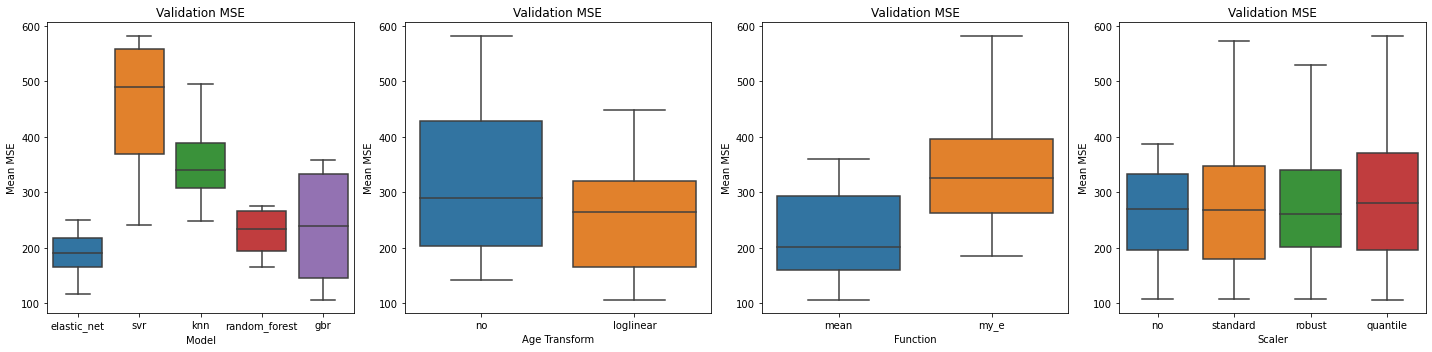

In [62]:
df = a
df.Function = df.Function.apply(lambda x: str(x)[10:14])
fig, axs = plt.subplots(1,4, tight_layout = True, figsize=(20,5))
axs[0].set_title('Validation MSE')
sns.boxplot(data = df, x = 'Model', y = 'Mean MSE', ax = axs[0], showfliers = False)
axs[1].set_title('Validation MSE')
sns.boxplot(data = df, x = 'Age Transform', y = 'Mean MSE', ax = axs[1], showfliers = False)
axs[2].set_title('Validation MSE')
sns.boxplot(data = df, x = 'Function', y = 'Mean MSE', ax = axs[2], showfliers = False)
axs[3].set_title('Validation MSE')
sns.boxplot(data = df, x = 'Scaler', y = 'Mean MSE', ax = axs[3], showfliers = False)
fig.show()